In [4]:
# init

import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, decomposition, manifold
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

In [5]:
# load data

data_train = pickle.load(open("./data/data-train.pkl", 'rb'))
print("training set (%i samples)" % data_train['rgb'].shape[0])
data_test = pickle.load(open("./data/data-test.pkl", 'rb'))
print("test set (%i samples)" % data_test['rgb'].shape[0])

training set (38000 samples)
test set (8190 samples)


In [4]:
# plot helper

def plot(imgs):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    plt.figure()
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        plt.imshow(imgs[i])

In [32]:
# crop and scale

proc_train = {id, pid, seg, rgb, dep, mask2, mask3, label}

for i in range(10):
    sample = data_train['segmentation'][i][:, :, 0]
    
    top = np.min(np.nonzero(np.any(sample, axis=1)))

    bottom = 120
    if not np.any(sample[119, :]):
        bottom = np.max(np.nonzero(np.any(sample, axis=1)))
        bottom = top+int((bottom-top)*0.85)
    
    height = bottom-top
    width = int((bottom-top)*0.75)
    factor = 120/height
    
    colsum = np.sum(sample, axis=0)
    
    left = np.min(np.nonzero(colsum))
    right = np.max(np.nonzero(colsum))
    
    cumsum = np.cumsum(colsum[left:right])
    
    avg = left+(np.abs(cumsum-np.average(cumsum))).argmin()
    
    left = 45+avg-int(45/factor)
    right = 45+avg+int(45/factor)
    
    seg_tmp = data_train['segmentation'][i].copy()
    seg_tmp = np.lib.pad(seg_tmp, ((0, 0), (45, 45), (0, 0)), 'constant', constant_values=0)
    
    rgb_tmp = data_train['rgb'][i].copy()
    rgb_tmp = np.lib.pad(rgb_tmp, ((0, 0), (45, 45), (0, 0)), 'edge')
    
    dep_tmp = data_train['depth'][i].copy()
    dep_tmp = np.lib.pad(dep_tmp, ((0, 0), (45, 45)), 'edge')
    
    seg = cv2.resize(seg_tmp[top:bottom, left:right, :] ,(90, 120), interpolation=cv2.INTER_CUBIC)
    rgb = cv2.resize(rgb_tmp[top:bottom, left:right, :] ,(90, 120), interpolation=cv2.INTER_CUBIC)
    dep = cv2.resize(dep_tmp[top:bottom, left:right] ,(90, 120), interpolation=cv2.INTER_CUBIC)
    
#     plot([seg, data_train['segmentation'][i]])
    
    seg_map2 = seg[:,:,0]>200
    seg_map = np.tile(seg[:,:,0]>200, (3,1,1)).transpose((1,2,0))
    seg_map = np.tile(seg[:,:,0]>200, (3,1,1)).transpose((1,2,0))
    
    img = seg_map2*dep
    
    orientations=8
    pixels_per_cell=(16,16)
    cells_per_block=(4,4)
    
    if len(img.shape) > 2:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
    hog_features, hog = feature.hog(img, orientations, pixels_per_cell, cells_per_block, visualise=True)
    
    plot([seg_map2*dep, hog])
    

SyntaxError: invalid syntax (<ipython-input-32-3a6d4fb0245e>, line 3)

[[  0   7   8   8   8   9  11  10   8  10   9   5 250 248 245 241 241 241
  245   5   5 244 240 240 240 240 240 240 240 240 240 251 246 241 240 226
  215 213 212 211 212 212 212 213 213 215 215 200 202 208 207 207 207 208
  208 206 198 239 245 243 241 241 241 241 241 242 242 242 243 243 243 242
  242 243 242 243 242 253   5 244 243 243 243 244 246 251  11  12  11   8]
 [  5   8   8   8   9  11  12  12  11  12  12  12  11  12  10   0 246 242
  249  12   5 241 240 240 240 240 240 240 240 242 255   9 246 240 241 209
  203 213 212 211 212 213 213 214 214 215 216 208 208 208 207 207 207 207
  207 208 198 227 241 241 241 241 241 241 241 242 242 242 242 242 242 242
  242 242 242 242 242 251   8 246 243 246 252 255   5  10  15  14  12   8]
 [253   9   9   9  10  11  12  12  11  12  12  12  12  12  13  12   7 254
    3  13   9 244 240 240 240 240 240 240 240 245   9  11 249 240 240 181
  163 212 212 211 212 213 213 214 215 214 218 212 226 215 208 207 207 208
  208 208 203 206 238 241 241 241 24

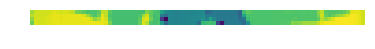

In [30]:
# normalize depth
print(data_train['depth'][0][28:32, :]-159)
plot(data_train['depth'][0][28:32, :])